<a href="https://colab.research.google.com/github/Jhancyamarsingh17/Automated-medical-report-generation-and-classification-/blob/main/Inception_model_for_medical_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Dependencies

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [5]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Training Inception to extract features from x rays 

1) Preparing Data in the tensorflow image from directory dataset 
Train Folder -> Class Foldes 

In [6]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                                                weights='imagenet',
                                               input_shape = (299, 299, 3))  

87910968/87910968 [==============================] - 0s 0us/step


In [7]:
base_model.trainable = True 

In [8]:
# Making the base model 
model_0 = tf.keras.Sequential(
    [
     tf.keras.layers.Input(shape = (299, 299, 3), name = "Input_layer"),
     base_model,
     tf.keras.layers.GlobalMaxPool2D(),
     tf.keras.layers.Dense(12, activation = "softmax")
    ]
)


In [9]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 21,827,372
Trainable params: 21,792,940
Non-trainable params: 34,432
_________________________________________________________________


### Loading in the model

In [10]:
## Visualizing the dataset 
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/indiana_reports.csv")
df.head()

uid                                               MeSH  \
0    1                                             normal   
1    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
2    3                                             normal   
3    4  Pulmonary Disease, Chronic Obstructive;Bullous...   
4    5  Osteophyte/thoracic vertebrae/multiple/small;T...   

                                            Problems  \
0                                             normal   
1                      Cardiomegaly;Pulmonary Artery   
2                                             normal   
3  Pulmonary Disease, Chronic Obstructive;Bullous...   
4                         Osteophyte;Thickening;Lung   

                                               image  \
0                          Xray Chest PA and Lateral   
1                Chest, 2 views, frontal and lateral   
2                          Xray Chest PA and Lateral   
3  PA and lateral views of the chest XXXX, XXXX a...   
4                          Xray Chest PA and Lateral   

                                          indication      comparison  \
0                                   Positive TB test           None.   
1                           Preop bariatric surgery.           None.   
2  rib pain after a XXXX, XXXX XXXX steps this XX...             NaN   
3                      XXXX-year-old XXXX with XXXX.  None available   
4                        Chest and nasal congestion.             NaN   

                                            findings  \
0  The cardiac silhouette and mediastinum size ar...   
1  Borderline cardiomegaly. Midline sternotomy XX...   
2                                                NaN   
3  There are diffuse bilateral interstitial and a...   
4  The cardiomediastinal silhouette and pulmonary...   

                                          impression  
0                               Normal chest x-XXXX.  
1                       No acute pulmonary findings.  
2  No displaced rib fractures, pneumothorax, or p...  
3  1. Bullous emphysema and interstitial fibrosis...  
4              No acute cardiopulmonary abnormality.

In [11]:
dff = pd.read_csv("/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/indiana_projections.csv")
dff.head()

uid                filename projection
0    1  1_IM-0001-4001.dcm.png    Frontal
1    1  1_IM-0001-3001.dcm.png    Lateral
2    2  2_IM-0652-1001.dcm.png    Frontal
3    2  2_IM-0652-2001.dcm.png    Lateral
4    3  3_IM-1384-1001.dcm.png    Frontal

In [12]:
dataframe = pd.merge(df, dff, on =['uid'])

In [13]:
dataframe = dataframe[dataframe.findings.notnull()]
dataframe.head()


uid                                               MeSH  \
0    1                                             normal   
1    1                                             normal   
2    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
6    4  Pulmonary Disease, Chronic Obstructive;Bullous...   

                                            Problems  \
0                                             normal   
1                                             normal   
2                      Cardiomegaly;Pulmonary Artery   
3                      Cardiomegaly;Pulmonary Artery   
6  Pulmonary Disease, Chronic Obstructive;Bullous...   

                                               image  \
0                          Xray Chest PA and Lateral   
1                          Xray Chest PA and Lateral   
2                Chest, 2 views, frontal and lateral   
3                Chest, 2 views, frontal and lateral   
6  PA and lateral views of the chest XXXX, XXXX a...   

                      indication      comparison  \
0               Positive TB test           None.   
1               Positive TB test           None.   
2       Preop bariatric surgery.           None.   
3       Preop bariatric surgery.           None.   
6  XXXX-year-old XXXX with XXXX.  None available   

                                            findings  \
0  The cardiac silhouette and mediastinum size ar...   
1  The cardiac silhouette and mediastinum size ar...   
2  Borderline cardiomegaly. Midline sternotomy XX...   
3  Borderline cardiomegaly. Midline sternotomy XX...   
6  There are diffuse bilateral interstitial and a...   

                                          impression                filename  \
0                               Normal chest x-XXXX.  1_IM-0001-4001.dcm.png   
1                               Normal chest x-XXXX.  1_IM-0001-3001.dcm.png   
2                       No acute pulmonary findings.  2_IM-0652-1001.dcm.png   
3                       No acute pulmonary findings.  2_IM-0652-2001.dcm.png   
6  1. Bullous emphysema and interstitial fibrosis...  4_IM-2050-1001.dcm.png   

  projection  
0    Frontal  
1    Lateral  
2    Frontal  
3    Lateral  
6    Frontal

In [14]:
len(dataframe)

6469

In [15]:
import string
import regex as re 
import nltk
from nltk.tokenize import word_tokenize

# nltk.download('stopwords')
# from nltk.corpus import stopwords
nltk.download('punkt')

def decontraction(doc):
    docs = re.sub(r"won't", "will not", doc)
    docs = re.sub(r"can\'t", "can not", docs)
    docs = re.sub(r"n\'t", " not", docs)
    docs = re.sub(r"\'re", " are", docs)
    docs = re.sub(r"\'s", " is", docs)
    docs = re.sub(r"\'d", " would", docs)
    docs = re.sub(r"\'ll", " will", docs)
    docs = re.sub(r"\'t", " not", docs)
    docs = re.sub(r"\'ve", " have", docs)
    docs = re.sub(r"\'m", " am",docs)
    docs = re.sub(r"n\'t", " not", docs)
    docs = re.sub(r"\'re", " are", docs)
    docs = re.sub(r"\'s", " is", docs)
    docs = re.sub(r"\'d", " would", docs)
    docs = re.sub(r"\'ll", " will", docs)
    docs = re.sub(r"\'t", " not", docs)
    docs = re.sub(r"\'ve", " have",docs)
    docs = re.sub(r"\'m", " am", docs)
    docs = re.sub(r"\*+", "abuse", docs)
    return docs

# def remove_stopwords(data):
#   all_stopwords = stopwords.words('english')
#   all_stopwords.remove('not')# removing the "not" from the stopwords
#   all_stopwords.remove('no')
#   text_tokens = word_tokenize(data) # tokenizing the sentence into word
#   tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
#   return " ".join(tokens_without_sw)

def text_preprocess(data):
  clean_text=[]
  text=str(data)
  # for i in (data.values):
  #   text = BeautifulSoup(i, 'lxml').get_text()
  text=text.lower()# making the text in lower case
  text=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",text)# removing the special character in text
  text=re.sub(r"xxxx","",text)# Removing the irrelavent XXXX words
  text=re.sub(r'xxx',"",text)
  text=re.sub(r'xx',"",text)
  text=re.sub(r'[0-9]',"",text)# Removing the number in text
  text = re.sub(r"yearold", "", text)
  text= re.sub('\s+',' ',text)
  text=re.sub("'",'',text)# Removing apoustahe
  text=re.sub(r'\.\.+', '.',text)# Removing multiple full stop
  text=re.sub(r'  ',"",text)
  text=decontraction(text)
  # text=remove_stopwords(text)
  
  return text
#  
dataframe["indication"]=dataframe["indication"].apply(lambda x:text_preprocess(x))
dataframe["findings"]=dataframe["findings"].apply(lambda x:text_preprocess(x))
dataframe["impression"]=dataframe["impression"].apply(lambda x:text_preprocess(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
dataframe.head()

uid                                               MeSH  \
0    1                                             normal   
1    1                                             normal   
2    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
6    4  Pulmonary Disease, Chronic Obstructive;Bullous...   

                                            Problems  \
0                                             normal   
1                                             normal   
2                      Cardiomegaly;Pulmonary Artery   
3                      Cardiomegaly;Pulmonary Artery   
6  Pulmonary Disease, Chronic Obstructive;Bullous...   

                                               image               indication  \
0                          Xray Chest PA and Lateral         positive tb test   
1                          Xray Chest PA and Lateral         positive tb test   
2                Chest, 2 views, frontal and lateral  preop bariatric surgery   
3                Chest, 2 views, frontal and lateral  preop bariatric surgery   
6  PA and lateral views of the chest XXXX, XXXX a...                    with    

       comparison                                           findings  \
0           None.  the cardiac silhouette and mediastinum size ar...   
1           None.  the cardiac silhouette and mediastinum size ar...   
2           None.  borderline cardiomegaly midline sternotomy enl...   
3           None.  borderline cardiomegaly midline sternotomy enl...   
6  None available  there are diffuse bilateral interstitial and a...   

                                          impression                filename  \
0                                     normal chest x  1_IM-0001-4001.dcm.png   
1                                     normal chest x  1_IM-0001-3001.dcm.png   
2                        no acute pulmonary findings  2_IM-0652-1001.dcm.png   
3                        no acute pulmonary findings  2_IM-0652-2001.dcm.png   
6   bullous emphysema and interstitial fibrosis p...  4_IM-2050-1001.dcm.png   

  projection  
0    Frontal  
1    Lateral  
2    Frontal  
3    Lateral  
6    Frontal

In [17]:
images = dataframe["filename"].tolist()

In [18]:
try_captions = dataframe["Problems"].tolist() + dataframe["indication"].tolist()

In [19]:
findings = list(dataframe["findings"])
indication = list(dataframe["indication"])
impression = list(dataframe["impression"])

In [20]:
len(findings), len(indication), len(impression)

(6469, 6469, 6469)

In [21]:
try_captions = []
b = 0
for a in range(len(findings)):
  captions = str("<start> "+"startseq " + "Indications: " + str(indication[a]) + " endseq " + "startseq " + "Findings: " + str(findings[a]) + " endseq "+"startseq " + "Impressions: " + str(impression[a]) + " endseq" + " <end>")
  try_captions.append(captions)

In [22]:
train_captions = try_captions
image_paths = []
for img in images:
  path = "/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/" + img
  image_paths.append(path)

In [23]:
dataframe.head()

uid                                               MeSH  \
0    1                                             normal   
1    1                                             normal   
2    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
6    4  Pulmonary Disease, Chronic Obstructive;Bullous...   

                                            Problems  \
0                                             normal   
1                                             normal   
2                      Cardiomegaly;Pulmonary Artery   
3                      Cardiomegaly;Pulmonary Artery   
6  Pulmonary Disease, Chronic Obstructive;Bullous...   

                                               image               indication  \
0                          Xray Chest PA and Lateral         positive tb test   
1                          Xray Chest PA and Lateral         positive tb test   
2                Chest, 2 views, frontal and lateral  preop bariatric surgery   
3                Chest, 2 views, frontal and lateral  preop bariatric surgery   
6  PA and lateral views of the chest XXXX, XXXX a...                    with    

       comparison                                           findings  \
0           None.  the cardiac silhouette and mediastinum size ar...   
1           None.  the cardiac silhouette and mediastinum size ar...   
2           None.  borderline cardiomegaly midline sternotomy enl...   
3           None.  borderline cardiomegaly midline sternotomy enl...   
6  None available  there are diffuse bilateral interstitial and a...   

                                          impression                filename  \
0                                     normal chest x  1_IM-0001-4001.dcm.png   
1                                     normal chest x  1_IM-0001-3001.dcm.png   
2                        no acute pulmonary findings  2_IM-0652-1001.dcm.png   
3                        no acute pulmonary findings  2_IM-0652-2001.dcm.png   
6   bullous emphysema and interstitial fibrosis p...  4_IM-2050-1001.dcm.png   

  projection  
0    Frontal  
1    Lateral  
2    Frontal  
3    Lateral  
6    Frontal

In [24]:
##  checking on the image and caption arrays 
image_paths[:5]

['/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/1_IM-0001-4001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/1_IM-0001-3001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/2_IM-0652-1001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/2_IM-0652-2001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/model3_shikha_chexnet_model_images.zip (Unzipped Files)/images/images_normalized/4_IM-2050-1001.dcm.png']

In [25]:
train_captions[:5]

['<start> startseq Indications: positive tb test endseq startseq Findings: the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothorax endseq startseq Impressions: normal chest x endseq <end>',
 '<start> startseq Indications: positive tb test endseq startseq Findings: the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothorax endseq startseq Impressions: normal chest x endseq <end>',
 '<start> startseq Indications: preop bariatric surgery endseq startseq Findings: borderline cardiomegaly midline sternotomy enlarged pulmonary arteries clear lungs inferior  endseq startseq Impressions: no acute pulmonary findings endseq <end>',
 '<start> startseq Indications: preop bariatric surgery endseq startseq Findings: b

### Preparing the Model

In [26]:
image_model = base_model
# image_model = chexnet

In [27]:
# image_model.summary()

In [28]:
# image_model = EfficientNetB0(include_top = False)
# image_model.trainable = True 

In [29]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [30]:
## Image feature Extractor Model
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [31]:
train_captions[:5], image_paths[:5]

(['<start> startseq Indications: positive tb test endseq startseq Findings: the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothorax endseq startseq Impressions: normal chest x endseq <end>',
  '<start> startseq Indications: positive tb test endseq startseq Findings: the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no of a pleural effusion there is no evidence of pneumothorax endseq startseq Impressions: normal chest x endseq <end>',
  '<start> startseq Indications: preop bariatric surgery endseq startseq Findings: borderline cardiomegaly midline sternotomy enlarged pulmonary arteries clear lungs inferior  endseq startseq Impressions: no acute pulmonary findings endseq <end>',
  '<start> startseq Indications: preop bariatric surgery endseq startseq Finding

In [32]:
# !pip install tqdm

In [33]:

from tqdm import tqdm

In [34]:
# Get unique images
encode_train = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 405/405 [29:55<00:00,  4.43s/it]


In [35]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

max_length = 100
# Use the top 9000 words for a vocabulary.
vocabulary_size = 9000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=max_length)
tokenizer.adapt(caption_dataset)

In [36]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [37]:
## Create word to tokens and tokens to words mapping 
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [38]:
## Split data to training and testing 
import collections
import random
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_paths, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [39]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(5175, 5175, 1294, 1294)

### Creating final data 

In [41]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 512
units = 1024
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2560
attention_features_shape = 64

In [42]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [43]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating the model

In [44]:
class CustomAttention(tf.keras.Model):
  def __init__(self, units):
    super(CustomAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

   
    # For unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [45]:
class CNN_Encoder(tf.keras.Model):
   
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [46]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = CustomAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention model
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))

    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [47]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [48]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [49]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [50]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training 

In [51]:
loss_plot = []

In [52]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initialize the hidden state for each batch
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

### 5 epochs

In [53]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.7963
Epoch 1 Loss 2.040581
Time taken for 1 epoch 546.76 sec

Epoch 2 Batch 0 Loss 1.3561
Epoch 2 Loss 1.338101
Time taken for 1 epoch 298.81 sec

Epoch 3 Batch 0 Loss 1.0073
Epoch 3 Loss 1.190506
Time taken for 1 epoch 292.67 sec

Epoch 4 Batch 0 Loss 1.1720
Epoch 4 Loss 1.106709
Time taken for 1 epoch 291.10 sec

Epoch 5 Batch 0 Loss 1.0077
Epoch 5 Loss 1.047050
Time taken for 1 epoch 289.67 sec



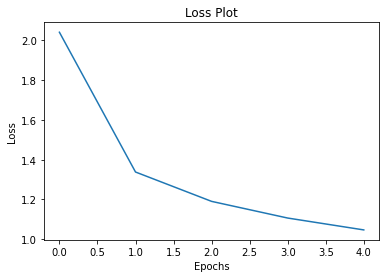

In [54]:
#after 5 epochs of training
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### 15 epochs

In [55]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.9318
Epoch 1 Loss 0.999725
Time taken for 1 epoch 289.32 sec

Epoch 2 Batch 0 Loss 0.8509
Epoch 2 Loss 0.961794
Time taken for 1 epoch 289.25 sec

Epoch 3 Batch 0 Loss 0.7773
Epoch 3 Loss 0.930809
Time taken for 1 epoch 288.57 sec

Epoch 4 Batch 0 Loss 0.8483
Epoch 4 Loss 0.897945
Time taken for 1 epoch 288.12 sec

Epoch 5 Batch 0 Loss 0.7858
Epoch 5 Loss 0.869288
Time taken for 1 epoch 286.57 sec

Epoch 6 Batch 0 Loss 0.7637
Epoch 6 Loss 0.839574
Time taken for 1 epoch 287.10 sec

Epoch 7 Batch 0 Loss 0.7318
Epoch 7 Loss 0.815430
Time taken for 1 epoch 287.41 sec

Epoch 8 Batch 0 Loss 0.8242
Epoch 8 Loss 0.783870
Time taken for 1 epoch 287.80 sec

Epoch 9 Batch 0 Loss 0.7646
Epoch 9 Loss 0.754710
Time taken for 1 epoch 288.40 sec

Epoch 10 Batch 0 Loss 0.6114
Epoch 10 Loss 0.721633
Time taken for 1 epoch 289.80 sec



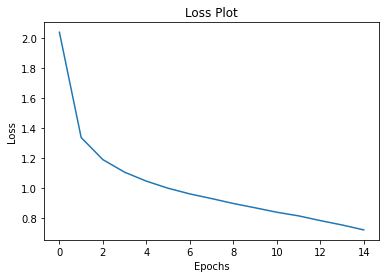

In [56]:
# after 15 epochs
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [57]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.6692
Epoch 1 Loss 0.704615
Time taken for 1 epoch 288.85 sec

Epoch 2 Batch 0 Loss 0.5969
Epoch 2 Loss 0.668420
Time taken for 1 epoch 287.80 sec

Epoch 3 Batch 0 Loss 0.6616
Epoch 3 Loss 0.638004
Time taken for 1 epoch 287.82 sec

Epoch 4 Batch 0 Loss 0.6432
Epoch 4 Loss 0.605388
Time taken for 1 epoch 287.96 sec

Epoch 5 Batch 0 Loss 0.5092
Epoch 5 Loss 0.572968
Time taken for 1 epoch 287.46 sec



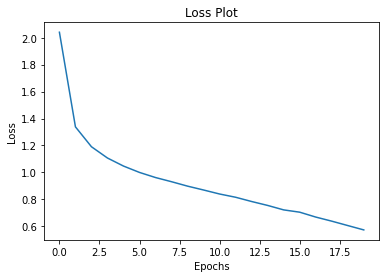

In [58]:
#after 20 epochs of training
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Caption

In [59]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
   
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [60]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(200, 200))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (80, 80))
        grid_size = max(int(np.ceil(len_result/2)), 1)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    # plt.tight_layout()
    plt.show()

In [61]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

chencherry = SmoothingFunction()

rid 136
bleu score is  0.20288313485401704
Real report:  indications chest pain findings the heart is normal in size the mediastinum is unremarkable the lungs are clear there is mild eventration of right hemidiaphragm no pleural effusion is seen impressions no acute disease
Predicted report:  indications male with chest pain findings no pleural effusion of pulmonary nodules bony destruction identified impressions large rounded stable the lungs are clear without focal infiltrate there is a stable mild interstitial are grossly grossly normal no pneumonia or pneumonia findings are grossly clear no pneumothorax the heart is large pulmonary appear within normal limits the lungs are clear and expanded heart and mediastinum normal impressions no acute cardiopulmonary abnormality or pneumothorax is noted impressions stable right diaphragm surgical clips are present the lungs are clear underlying


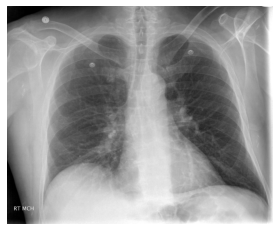

In [65]:
rid = np.random.randint(0, len(img_name_val))
print('rid', rid)
image = img_name_val[rid]
img = plt.imread(image)
plt.figure()
plt.imshow(img, cmap = "gray")
plt.axis(False)
real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]]
result, attention_plot = evaluate(image)
rem = ['startseq', 'start', 'end', 'endseq']
real_caption  = [x for x in real_caption if x not in rem]
result  = [x for x in result if x not in rem]
bl=sentence_bleu([result], real_caption,weights=(1, 0, 0, 0), smoothing_function=chencherry.method5)
print("bleu score is ",bl)
print('Real report: ', ' '.join([i for i in real_caption]))
print('Predicted report: ', ' '.join(result))

# plot_attention(image, result, attention_plot)

### Calculating the performace of the model using BLEU Score

In [67]:

index=len(img_name_val)
cols = ['image', 'real','pred','blue']
dat = pd.DataFrame(columns = cols)
bl=0
df_predicted_res = pd.DataFrame()
nums= 50
for j in range(nums):

  image = img_name_val[j]
  real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[j] if i not in [0]]
  
  result, attention_plot = evaluate(image)
  #removing the start and end tags we initially added
  rem = ['startseq', 'start', 'end', 'endseq']
  real_caption  = [x for x in real_caption if x not in rem]
  result  = [x for x in result if x not in rem]
  
  print('Real report: ', ' '.join([i for i in real_caption]))
  print('Predicted report: ', ' '.join(result))

  chencherry = SmoothingFunction()
  bl+=sentence_bleu([result], real_caption,weights=(1, 0, 0, 0), smoothing_function=chencherry.method5)
  print('Bleu score: ', sentence_bleu([result], real_caption,weights=(1, 0, 0, 0), smoothing_function=chencherry.method5))
  real_cap =  ' '.join([i for i in real_caption])
  pred_cap = ' '.join(result)
  dat = dat.append({'image': image, 'real':real_cap,'pred':pred_cap,'blue':bl},ignore_index=True)
  print('*'*100)
print("average bleu score on the test data is ",bl/nums)
dat.to_csv('/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/shikha_real_vs_predicted.csv')

Real report:  indications melanoma dx no chest complaints findings the lungs appear clear there are no suspicious pulmonary nodules or masses density in the left lung base represents atelectasis or scarring the heart and very are normal pleural spaces are clear surgical clips are identified in the left axilla there is lucency involving the lateral aspect of the left clavicle metastatic disease cannot be excluded impressions lucency in the left lateral clavicle near the acromioclavicular joint metastatic disease is possible clear lungs
Predicted report:  indications copd knee pain under left chest pain findings heart size and pulmonary vascularity appear within normal limits atherosclerotic calcifications of a descending thoracic aorta is seen impressions no acute process or pneumothorax impressions no acute cardiopulmonary abnormality no acute cardiopulmonary abnormalities or noncalcified nodule calcified granuloma is seen mild basilar atelectasis or atelectasis degenerative changes ar

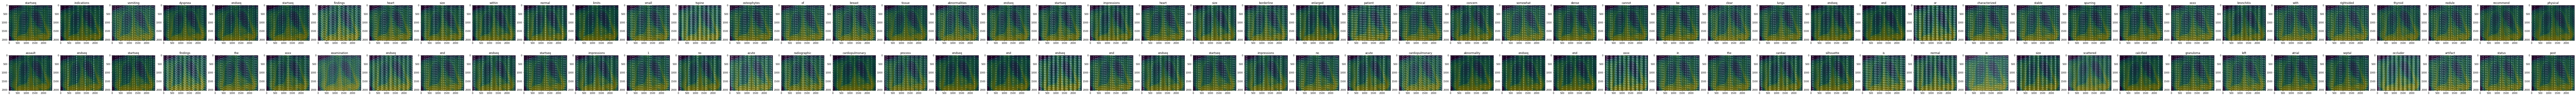

In [ ]:
plot_attention(image, result, attention_plot)